In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import resultcomp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import plots
import json
import numpy as np
import os
mpl.rcParams['figure.dpi'] = 300
results_dir = './../../results'

In [3]:
def string_range(strings, start=None, end=None):
    keep = []
    include = False
    for string in strings:
        if string.startswith(start):
            include = True
        if include:
            keep.append(string)
        if end is not None and string.startswith(end):
            include = False
    return keep

def calc_mse(dms, df, gt='groundtruth_sum', md='model_sum'):
    sq_errs = np.square(np.subtract(dms[gt], dms[md]))
    for model in dms.index.get_level_values(level=0).unique():
        if not model.endswith("-baseline"):
            with open(results_dir + '/' + model + '/parameters.json') as f:
                d = json.load(f)
            
            df2 = pd.DataFrame({'directory': [model], 'p': [d['model']['p']], 'gamma': [d['model']['gamma']], 'beta': [d['model']['region_sampling']['beta']], 'mse': [sq_errs.loc[model].mean()]})
        else:
            df2 = pd.DataFrame({'directory': [model], 'p': [None], 'gamma': [None], 'beta': [None], 'mse': [sq_errs.loc[model].mean()]})
        df = df.append(df2)
    return df

def generic_load_mse(start, end):
    result_directories = sorted(os.listdir(results_dir))
    directories = string_range(result_directories, start, end)
    metrics = None
    for d in directories:
        p = "{}/{}/distance-metrics.csv".format(results_dir, d)
        if not os.path.exists(p):
            continue
        s = pd.read_csv(p)
        s = s.assign(run_id=d).set_index(['run_id', 'distance'])
        if metrics is None:
            metrics = s
        else:
            metrics = pd.concat([metrics, s])

            df = pd.DataFrame(columns=['directory', 'p', 'gamma', 'beta', 'mse'])
    df = calc_mse(metrics, df).set_index('directory')
    return df

def load_mse():
    # Sweden
    swe_mse = resultcomp.results_mse(
        directories=None, 
        start='20200515_173829', 
        end='20200518_050952', 
        include_model=True,
    ).set_index('directory')
    swe_mse = swe_mse.groupby(['directory', 'p', 'gamma','beta']).sum()[['mse']].reset_index()
    # Not sure why yet
    swe_mse = swe_mse.drop(7)
    
    # Sao Paulo
    sao_mse = generic_load_mse('saopaulo-20200518_170056', 'saopaulo-baseline')
    sao_mse = sao_mse.drop('saopaulo-20200519_224039')
    sao_mse = sao_mse.reset_index()
    
    # Netherlands
    neth_mse = generic_load_mse('netherlands-20200518_235511', 'netherlands-baseline')
    neth_mse = neth_mse.reset_index()
    
    return pd.concat([
        swe_mse.assign(region='sweden'),
        sao_mse.assign(region='saopaulo'),
        neth_mse.assign(region='netherlands')
    ]).set_index('region')

mse = load_mse()

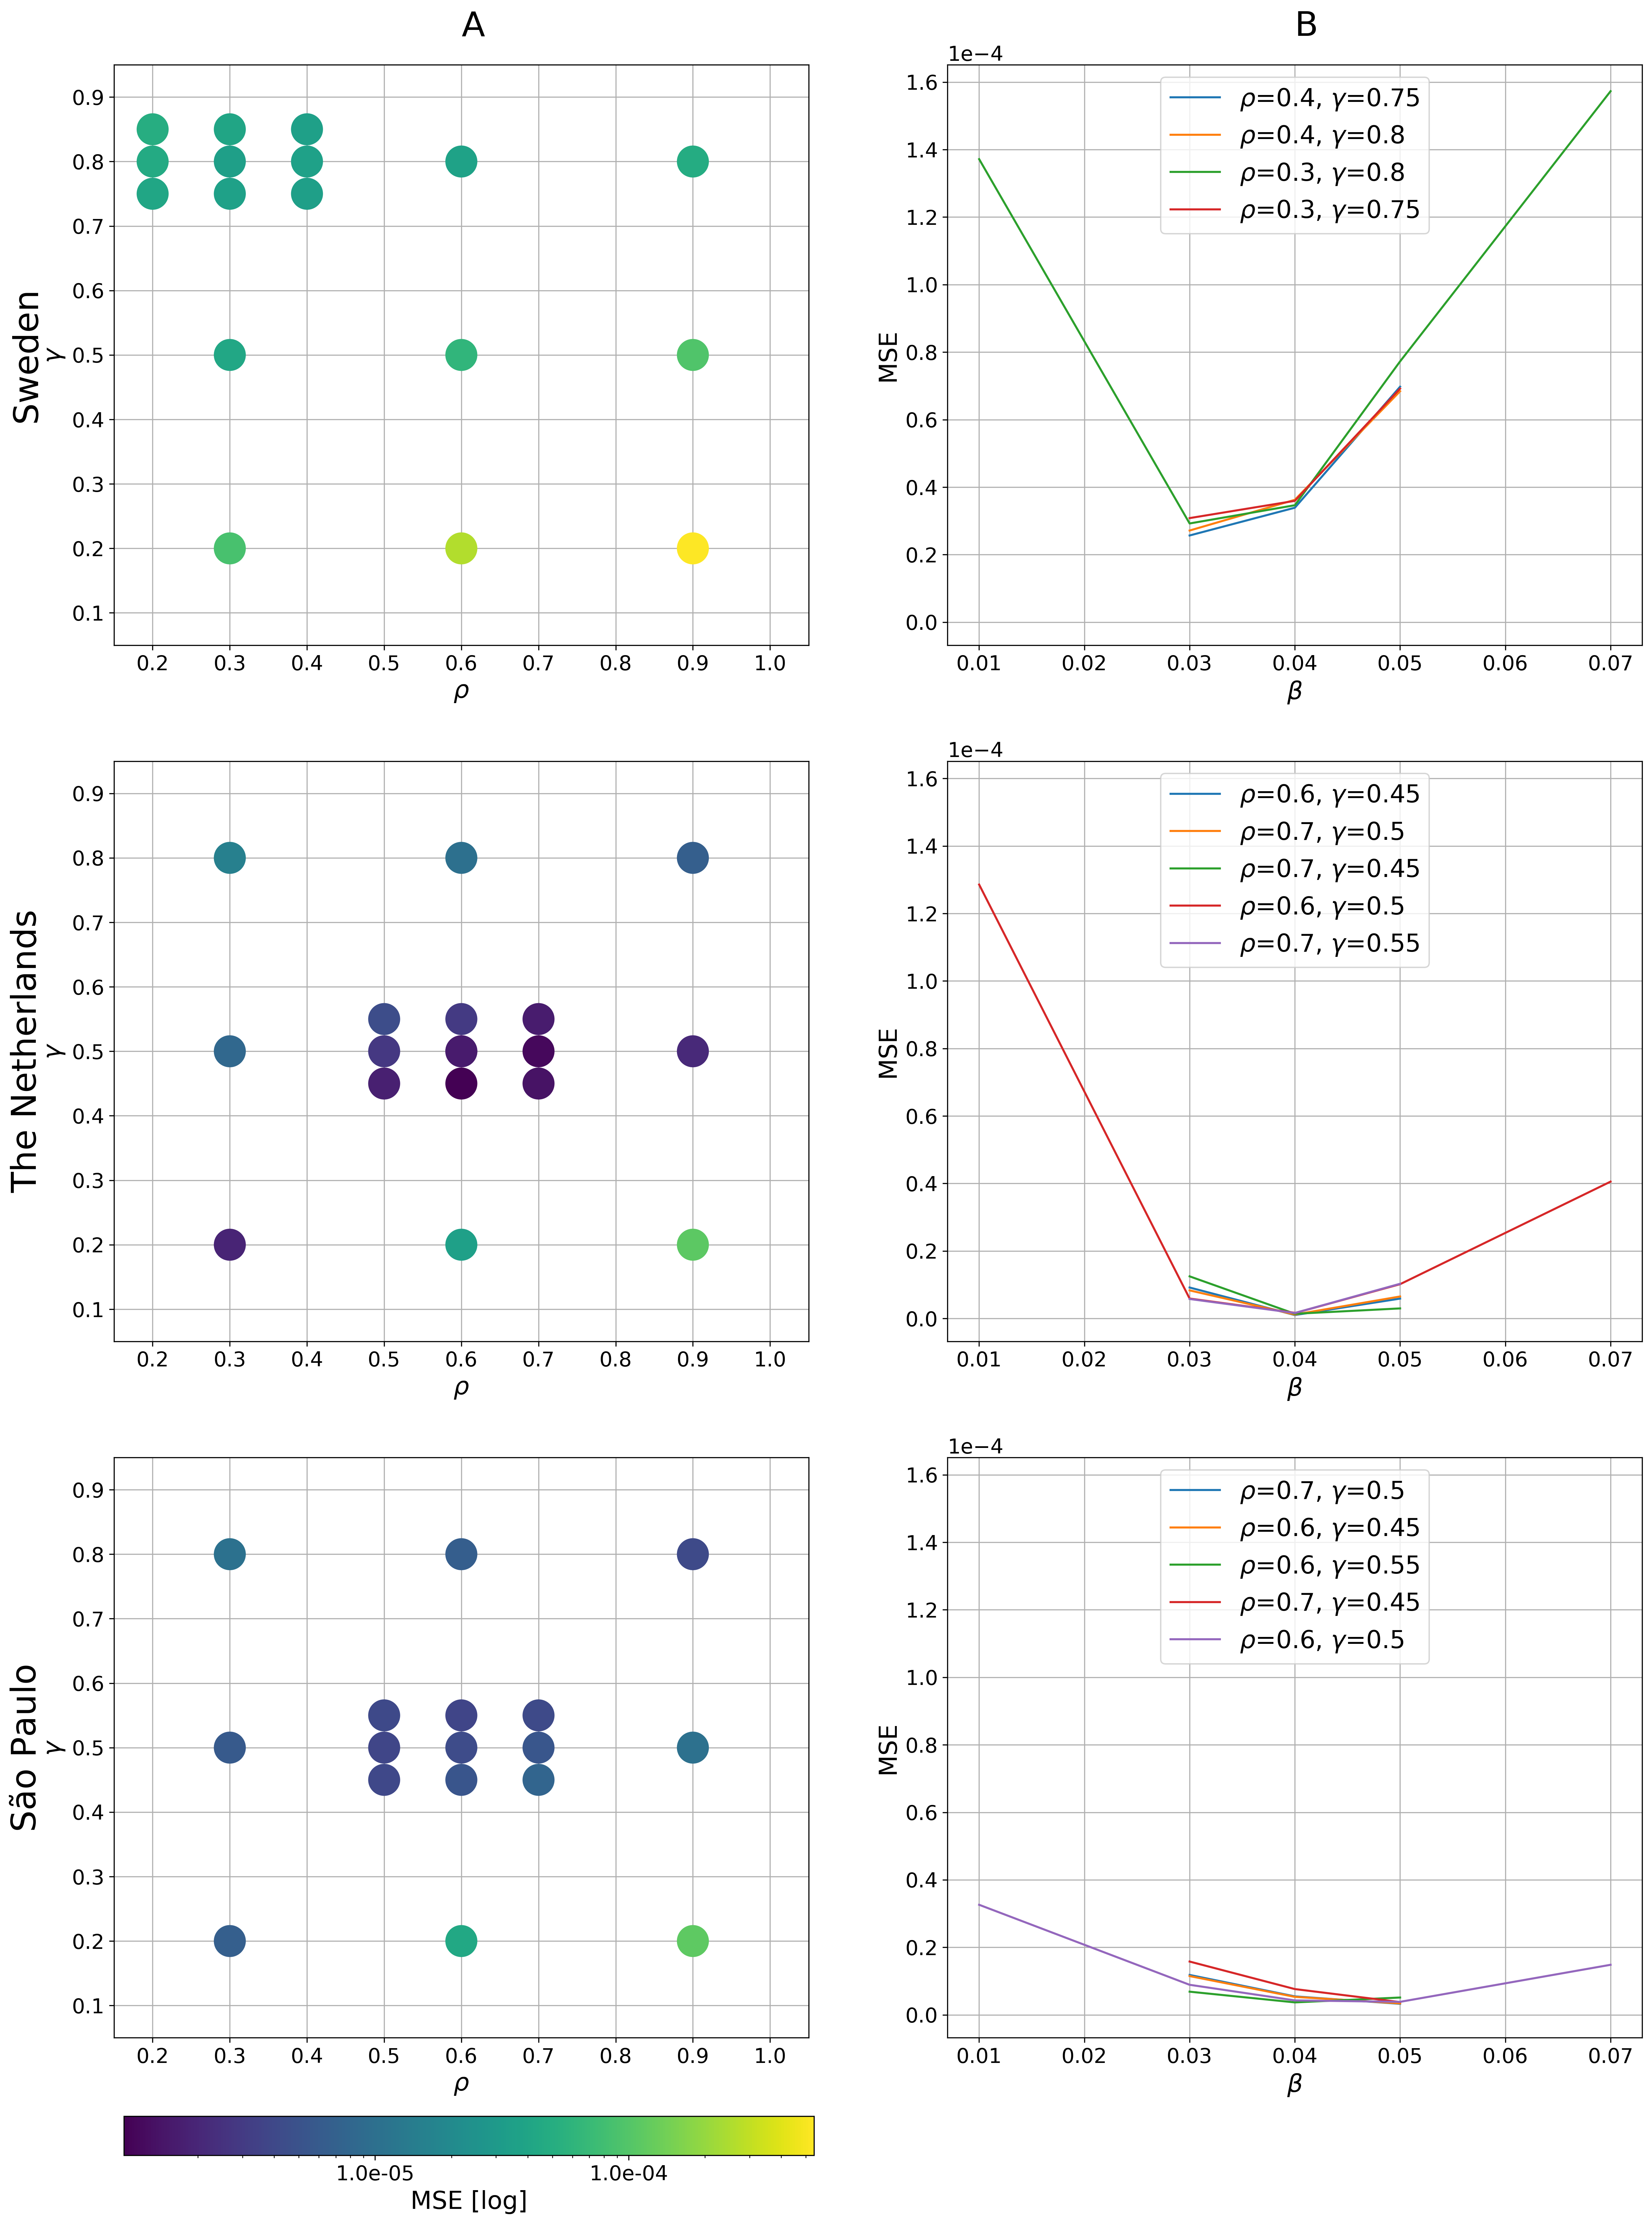

In [14]:
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
regions = ['sweden', 'netherlands', 'saopaulo']
selected_beta = {
    "sweden": 0.04,
    "netherlands": 0.04,
    "saopaulo": 0.04,
}

selected_explorations = {
    "sweden": [[0.4,0.75], [0.4, 0.8], [0.3,0.8], [0.3,0.75]],
    "netherlands": [[0.6,0.45], [0.7, 0.5], [0.7,0.45], [0.6,0.5], [0.7,0.55]],
    "saopaulo": [[0.7,0.5], [0.6, 0.45], [0.6,0.55], [0.7,0.45], [0.6,0.5]]
}

titles = {
    "sweden": "Sweden",
    "netherlands": "The Netherlands",
    "saopaulo": "São Paulo"
}


fig, axes = plt.subplots(3, 2, figsize=(20, 26.5), sharey='col')

vmin = 999
vmax = 0
for r in regions:
    d = mse[mse.beta == selected_beta[r]]
    vmin = min(vmin, d.mse.min())
    vmax = max(vmax, d.mse.max())

cbar_norm = mpl.colors.LogNorm(vmin, vmax)

for (region, i) in zip(regions, range(3)):
    axes[i,0].set_xticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.])
    axes[i,0].set_yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.])
    axes[i,0].set_xlim((0.15, 1.05))
    axes[i,0].set_ylim((0.05, 0.95))
    
    exploration_plot_data = mse.loc[region]
    exploration_plot_data = exploration_plot_data[exploration_plot_data.beta == selected_beta[region]]
    
    s = axes[i,0].scatter(
        exploration_plot_data.p,
        exploration_plot_data.gamma,
        c=exploration_plot_data.mse,
        norm=cbar_norm,
        s=500,
        zorder=2
    )
    axes[i,0].set_xlabel(r'$\rho$', fontsize=18)
    axes[i,0].set_ylabel(r'$\gamma$', fontsize=18)
    axes[i,0].grid(True)

    axes[i,0].text(
        -0.15, .5, 
        titles[region], 
        rotation=90, 
        va='center',
        transform=axes[i,0].transAxes,
        fontsize='25',
    )

cax = fig.add_axes([0.13, 0.08, .35, 0.015])
cbar = fig.colorbar(s, ax=axes[2,0], cax=cax, format='%.1e', orientation="horizontal", norm=cbar_norm)
cbar.ax.set_xlabel('MSE [log]', fontsize=18, rotation=0)
#cbar.ax.yaxis.set_label_position('left')
axes[0,0].text(.5, 1.05, "A", transform=axes[0,0].transAxes, fontsize='25')
axes[0,1].text(.5, 1.05, "B", transform=axes[0,1].transAxes, fontsize='25')

for (region, i) in zip(regions, range(3)):
    data = mse.loc[region]
    
    for (rho, gamma) in selected_explorations[region]:
        
        beta_plot_data = data[(data.p == rho) & (data.gamma == gamma)].sort_values(by='beta')
        axes[i,1].plot(
            beta_plot_data.beta, 
            beta_plot_data.mse, 
            label=r'$\rho$={}, $\gamma$={}'.format(rho, gamma),
        )
        
    axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    axes[i,1].grid(True)
    axes[i,1].legend(loc='upper center', fontsize=18)
    axes[i,1].set_xlabel(r'$\beta$', fontsize=18)
    axes[i,1].set_ylabel('MSE', fontsize=18)

In [40]:
prints = mse.loc["saopaulo"].reset_index().sort_values(by='mse')[['p', 'gamma', 'beta', 'mse']]
prints.mse = prints.mse * (10**5)
prints.mse = round(prints.mse * 100) / 100
prints.to_clipboard(sep="&", index=False)

In [ ]:
p&gamma&beta&mse
0.7&0.5&0.05&0.33
0.6&0.45&0.05&0.34
0.6&0.55&0.04&0.37
0.7&0.45&0.05&0.38
0.5&0.5&0.04&0.38
0.6&0.5&0.05&0.39
0.7&0.55&0.05&0.39
0.5&0.45&0.04&0.4
0.5&0.55&0.04&0.4
0.9&0.5&0.07&0.41
0.9&0.8&0.04&0.42
0.7&0.55&0.04&0.42
0.6&0.5&0.04&0.43
0.5&0.45&0.05&0.43
0.6&0.55&0.05&0.51
0.6&0.45&0.04&0.53
0.5&0.5&0.05&0.54
0.7&0.5&0.04&0.55
0.5&0.55&0.03&0.55
0.3&0.5&0.04&0.58
0.6&0.8&0.04&0.64
0.3&0.2&0.04&0.66
0.5&0.5&0.03&0.67
0.6&0.55&0.03&0.69
0.5&0.55&0.05&0.71
0.7&0.45&0.04&0.76
0.3&0.2&0.07&0.79
0.5&0.45&0.03&0.82
0.6&0.5&0.03&0.89
0.7&0.55&0.03&0.92
0.9&0.5&0.04&1.04
0.3&0.8&0.04&1.06
0.6&0.45&0.03&1.15
0.7&0.5&0.03&1.18
0.3&0.8&0.01&1.29
0.6&0.2&0.07&1.39
0.6&0.5&0.07&1.48
0.7&0.45&0.03&1.58
0.6&0.8&0.01&1.76
0.3&0.5&0.01&1.86
0.9&0.8&0.01&2.33
0.9&0.8&0.07&2.95
0.6&0.5&0.01&3.26
0.3&0.5&0.07&3.75
0.3&0.2&0.01&4.02
0.6&0.8&0.07&4.09
0.6&0.2&0.04&4.39
0.9&0.5&0.01&5.12
0.3&0.8&0.07&5.67
0.9&0.2&0.07&7.15
0.6&0.2&0.01&9.75
0.9&0.2&0.04&11.32
0.9&0.2&0.01&16.83
